In [75]:
import pandas as pd

pd.Index([1,2,3]).difference(pd.Index([2,3,4]))

Index([1], dtype='int64')

In [187]:
import re
import sys
import requests
import numpy as np
import pandas as pd
from pathlib import Path
from urllib import parse

sys.path.append(str(Path.cwd().parent / "scripts"))

from build_base import build_sp_register

year_file = Path.cwd().parent / "data" / "year-ahead-constraint-limits.csv"
two_year_file = Path.cwd().parent / "data" / "24-months-ahead-constraint-limit_060924.csv"


def build_boundary_flow_limits(date_range):

    boundaries = pd.Index(['SSE-SP', 'SCOTEX', 'SSHARN', 'FLOWSTH', 'SEIMP'])

    # request to national grid ESO is made in London time
    start = (
        date_range[0]
        .tz_convert('Europe/London')
    )
    end = (
        date_range[-1]
        .tz_convert('Europe/London')
    )

    sql_query = (
        '''SELECT COUNT(*) OVER () AS _count, * FROM "38a18ec1-9e40-465d-93fb-301e80fd1352"'''+
        ''' WHERE "Date (GMT/BST)" >= '{}' '''.format(start.strftime("%Y-%m-%d %H:%M:%S")) +
        '''AND "Date (GMT/BST)" <= '{}' '''.format(end.strftime("%Y-%m-%d %H:%M:%S")) +
        '''ORDER BY "_id" ASC LIMIT 1000'''
    )

    params = {'sql': sql_query}

    response = requests.get(
        'https://api.nationalgrideso.com/api/3/action/datastore_search_sql',
        params=parse.urlencode(params)
        )

    data = response.json()["result"]

    if not data['records']:
        print(f"No data found for {date_range[0].strftime('%Y-%m-%d')}")
        return pd.DataFrame(np.nan, index=date_range, columns=boundaries)
    
    df = (
        pd.DataFrame(data["records"])
        .set_index("Constraint Group")
        [["_count", "Limit (MW)", "Flow (MW)", "Date (GMT/BST)"]]
        .rename(columns={
            "Limit (MW)": "limit",
            "Flow (MW)": "flow",
            "Date (GMT/BST)": "date",
            })
        .drop(columns=['_count'])
    )

    df = df.set_index('date', append=True)['limit'].unstack().T
    df[df >= 15_000] = np.nan

    print(df.shape)
    print(df.index)

    df.index = (
        pd.to_datetime(df.index)
        .tz_localize('Europe/London', ambiguous='')
        .tz_convert('UTC')
    )

    number_split = lambda x: re.split(r'\d', x, maxsplit=1)[0]
    def match_and_cut(index, true_names):

        new_index = pd.Index(map(number_split, index)).intersection(true_names)
        old_index = pd.Index([i for i in index if number_split(i) in new_index])

        return {
            old: new for new, old in zip(new_index, old_index)
        }

    renamer = match_and_cut(df.columns, boundaries)
    
    df = (
        pd.concat((
            df[renamer.keys()].rename(columns=renamer),
            pd.DataFrame(
                np.nan, index=df.index,
                columns=boundaries.difference(renamer.values())
                )
        ), axis=1).loc[:, boundaries]
    )

    return df




ds = []
from tqdm import tqdm

year = '2022'

# for day in tqdm(pd.date_range(f'{year}-01-01', f'{year}-12-31')):
for day in tqdm(pd.date_range(f'{year}-10-30', f'{year}-10-31')):
    day = day.strftime("%Y-%m-%d")

    sp_register = build_sp_register(day)
    date_range = sp_register.index
    print(date_range.shape)
    print(date_range)

    df = build_boundary_flow_limits(date_range)
    ds.append(df)

pd.concat(ds).to_csv(f'constraint_limits_{year}.csv')

  0%|          | 0/2 [00:00<?, ?it/s]

(50,)
DatetimeIndex(['2022-10-29 23:00:00+00:00', '2022-10-29 23:30:00+00:00',
               '2022-10-30 00:00:00+00:00', '2022-10-30 00:30:00+00:00',
               '2022-10-30 01:00:00+00:00', '2022-10-30 01:30:00+00:00',
               '2022-10-30 02:00:00+00:00', '2022-10-30 02:30:00+00:00',
               '2022-10-30 03:00:00+00:00', '2022-10-30 03:30:00+00:00',
               '2022-10-30 04:00:00+00:00', '2022-10-30 04:30:00+00:00',
               '2022-10-30 05:00:00+00:00', '2022-10-30 05:30:00+00:00',
               '2022-10-30 06:00:00+00:00', '2022-10-30 06:30:00+00:00',
               '2022-10-30 07:00:00+00:00', '2022-10-30 07:30:00+00:00',
               '2022-10-30 08:00:00+00:00', '2022-10-30 08:30:00+00:00',
               '2022-10-30 09:00:00+00:00', '2022-10-30 09:30:00+00:00',
               '2022-10-30 10:00:00+00:00', '2022-10-30 10:30:00+00:00',
               '2022-10-30 11:00:00+00:00', '2022-10-30 11:30:00+00:00',
               '2022-10-30 12:00:00+00:00', '

  0%|          | 0/2 [00:00<?, ?it/s]

(48, 9)
Index(['2022-10-30T00:00:00', '2022-10-30T00:30:00', '2022-10-30T01:00:00',
       '2022-10-30T01:30:00', '2022-10-30T02:00:00', '2022-10-30T02:30:00',
       '2022-10-30T03:00:00', '2022-10-30T03:30:00', '2022-10-30T04:00:00',
       '2022-10-30T04:30:00', '2022-10-30T05:00:00', '2022-10-30T05:30:00',
       '2022-10-30T06:00:00', '2022-10-30T06:30:00', '2022-10-30T07:00:00',
       '2022-10-30T07:30:00', '2022-10-30T08:00:00', '2022-10-30T08:30:00',
       '2022-10-30T09:00:00', '2022-10-30T09:30:00', '2022-10-30T10:00:00',
       '2022-10-30T10:30:00', '2022-10-30T11:00:00', '2022-10-30T11:30:00',
       '2022-10-30T12:00:00', '2022-10-30T12:30:00', '2022-10-30T13:00:00',
       '2022-10-30T13:30:00', '2022-10-30T14:00:00', '2022-10-30T14:30:00',
       '2022-10-30T15:00:00', '2022-10-30T15:30:00', '2022-10-30T16:00:00',
       '2022-10-30T16:30:00', '2022-10-30T17:00:00', '2022-10-30T17:30:00',
       '2022-10-30T18:00:00', '2022-10-30T18:30:00', '2022-10-30T19:00:00',
    

AmbiguousTimeError: Cannot infer dst time from 2022-10-30 01:00:00, try using the 'ambiguous' argument

In [184]:
print(pd.date_range('2022-10-30', '2022-10-31', freq='30min', tz='UTC'))
print(pd.date_range('2022-10-30', '2022-10-31', freq='30min', tz='UTC').shape)
print(pd.date_range('2022-10-30', '2022-10-31', freq='30min', tz='Europe/London'))
print(pd.date_range('2022-10-30', '2022-10-31', freq='30min', tz='Europe/London').shape)

DatetimeIndex(['2022-10-30 00:00:00+00:00', '2022-10-30 00:30:00+00:00',
               '2022-10-30 01:00:00+00:00', '2022-10-30 01:30:00+00:00',
               '2022-10-30 02:00:00+00:00', '2022-10-30 02:30:00+00:00',
               '2022-10-30 03:00:00+00:00', '2022-10-30 03:30:00+00:00',
               '2022-10-30 04:00:00+00:00', '2022-10-30 04:30:00+00:00',
               '2022-10-30 05:00:00+00:00', '2022-10-30 05:30:00+00:00',
               '2022-10-30 06:00:00+00:00', '2022-10-30 06:30:00+00:00',
               '2022-10-30 07:00:00+00:00', '2022-10-30 07:30:00+00:00',
               '2022-10-30 08:00:00+00:00', '2022-10-30 08:30:00+00:00',
               '2022-10-30 09:00:00+00:00', '2022-10-30 09:30:00+00:00',
               '2022-10-30 10:00:00+00:00', '2022-10-30 10:30:00+00:00',
               '2022-10-30 11:00:00+00:00', '2022-10-30 11:30:00+00:00',
               '2022-10-30 12:00:00+00:00', '2022-10-30 12:30:00+00:00',
               '2022-10-30 13:00:00+00:00', '2022-1

ConversionError: Failed to convert value(s) to axis units: array([Timestamp('2022-10-29 23:00:00+0000', tz='UTC'),
       Timestamp('2022-10-29 23:30:00+0000', tz='UTC'), NaT, NaT,
       Timestamp('2022-10-30 02:00:00+0000', tz='UTC'),
       Timestamp('2022-10-30 02:30:00+0000', tz='UTC'),
       Timestamp('2022-10-30 03:00:00+0000', tz='UTC'),
       Timestamp('2022-10-30 03:30:00+0000', tz='UTC'),
       Timestamp('2022-10-30 04:00:00+0000', tz='UTC'),
       Timestamp('2022-10-30 04:30:00+0000', tz='UTC'),
       Timestamp('2022-10-30 05:00:00+0000', tz='UTC'),
       Timestamp('2022-10-30 05:30:00+0000', tz='UTC'),
       Timestamp('2022-10-30 06:00:00+0000', tz='UTC'),
       Timestamp('2022-10-30 06:30:00+0000', tz='UTC'),
       Timestamp('2022-10-30 07:00:00+0000', tz='UTC'),
       Timestamp('2022-10-30 07:30:00+0000', tz='UTC'),
       Timestamp('2022-10-30 08:00:00+0000', tz='UTC'),
       Timestamp('2022-10-30 08:30:00+0000', tz='UTC'),
       Timestamp('2022-10-30 09:00:00+0000', tz='UTC'),
       Timestamp('2022-10-30 09:30:00+0000', tz='UTC'),
       Timestamp('2022-10-30 10:00:00+0000', tz='UTC'),
       Timestamp('2022-10-30 10:30:00+0000', tz='UTC'),
       Timestamp('2022-10-30 11:00:00+0000', tz='UTC'),
       Timestamp('2022-10-30 11:30:00+0000', tz='UTC'),
       Timestamp('2022-10-30 12:00:00+0000', tz='UTC'),
       Timestamp('2022-10-30 12:30:00+0000', tz='UTC'),
       Timestamp('2022-10-30 13:00:00+0000', tz='UTC'),
       Timestamp('2022-10-30 13:30:00+0000', tz='UTC'),
       Timestamp('2022-10-30 14:00:00+0000', tz='UTC'),
       Timestamp('2022-10-30 14:30:00+0000', tz='UTC'),
       Timestamp('2022-10-30 15:00:00+0000', tz='UTC'),
       Timestamp('2022-10-30 15:30:00+0000', tz='UTC'),
       Timestamp('2022-10-30 16:00:00+0000', tz='UTC'),
       Timestamp('2022-10-30 16:30:00+0000', tz='UTC'),
       Timestamp('2022-10-30 17:00:00+0000', tz='UTC'),
       Timestamp('2022-10-30 17:30:00+0000', tz='UTC'),
       Timestamp('2022-10-30 18:00:00+0000', tz='UTC'),
       Timestamp('2022-10-30 18:30:00+0000', tz='UTC'),
       Timestamp('2022-10-30 19:00:00+0000', tz='UTC'),
       Timestamp('2022-10-30 19:30:00+0000', tz='UTC'),
       Timestamp('2022-10-30 20:00:00+0000', tz='UTC'),
       Timestamp('2022-10-30 20:30:00+0000', tz='UTC'),
       Timestamp('2022-10-30 21:00:00+0000', tz='UTC'),
       Timestamp('2022-10-30 21:30:00+0000', tz='UTC'),
       Timestamp('2022-10-30 22:00:00+0000', tz='UTC'),
       Timestamp('2022-10-30 22:30:00+0000', tz='UTC'),
       Timestamp('2022-10-30 23:00:00+0000', tz='UTC'),
       Timestamp('2022-10-30 23:30:00+0000', tz='UTC'),
       Timestamp('2022-10-31 00:00:00+0000', tz='UTC'),
       Timestamp('2022-10-31 00:30:00+0000', tz='UTC'),
       Timestamp('2022-10-31 01:00:00+0000', tz='UTC'),
       Timestamp('2022-10-31 01:30:00+0000', tz='UTC'),
       Timestamp('2022-10-31 02:00:00+0000', tz='UTC'),
       Timestamp('2022-10-31 02:30:00+0000', tz='UTC'),
       Timestamp('2022-10-31 03:00:00+0000', tz='UTC'),
       Timestamp('2022-10-31 03:30:00+0000', tz='UTC'),
       Timestamp('2022-10-31 04:00:00+0000', tz='UTC'),
       Timestamp('2022-10-31 04:30:00+0000', tz='UTC'),
       Timestamp('2022-10-31 05:00:00+0000', tz='UTC'),
       Timestamp('2022-10-31 05:30:00+0000', tz='UTC'),
       Timestamp('2022-10-31 06:00:00+0000', tz='UTC'),
       Timestamp('2022-10-31 06:30:00+0000', tz='UTC'),
       Timestamp('2022-10-31 07:00:00+0000', tz='UTC'),
       Timestamp('2022-10-31 07:30:00+0000', tz='UTC'),
       Timestamp('2022-10-31 08:00:00+0000', tz='UTC'),
       Timestamp('2022-10-31 08:30:00+0000', tz='UTC'),
       Timestamp('2022-10-31 09:00:00+0000', tz='UTC'),
       Timestamp('2022-10-31 09:30:00+0000', tz='UTC'),
       Timestamp('2022-10-31 10:00:00+0000', tz='UTC'),
       Timestamp('2022-10-31 10:30:00+0000', tz='UTC'),
       Timestamp('2022-10-31 11:00:00+0000', tz='UTC'),
       Timestamp('2022-10-31 11:30:00+0000', tz='UTC'),
       Timestamp('2022-10-31 12:00:00+0000', tz='UTC'),
       Timestamp('2022-10-31 12:30:00+0000', tz='UTC'),
       Timestamp('2022-10-31 13:00:00+0000', tz='UTC'),
       Timestamp('2022-10-31 13:30:00+0000', tz='UTC'),
       Timestamp('2022-10-31 14:00:00+0000', tz='UTC'),
       Timestamp('2022-10-31 14:30:00+0000', tz='UTC'),
       Timestamp('2022-10-31 15:00:00+0000', tz='UTC'),
       Timestamp('2022-10-31 15:30:00+0000', tz='UTC'),
       Timestamp('2022-10-31 16:00:00+0000', tz='UTC'),
       Timestamp('2022-10-31 16:30:00+0000', tz='UTC'),
       Timestamp('2022-10-31 17:00:00+0000', tz='UTC'),
       Timestamp('2022-10-31 17:30:00+0000', tz='UTC'),
       Timestamp('2022-10-31 18:00:00+0000', tz='UTC'),
       Timestamp('2022-10-31 18:30:00+0000', tz='UTC'),
       Timestamp('2022-10-31 19:00:00+0000', tz='UTC'),
       Timestamp('2022-10-31 19:30:00+0000', tz='UTC'),
       Timestamp('2022-10-31 20:00:00+0000', tz='UTC'),
       Timestamp('2022-10-31 20:30:00+0000', tz='UTC'),
       Timestamp('2022-10-31 21:00:00+0000', tz='UTC'),
       Timestamp('2022-10-31 21:30:00+0000', tz='UTC'),
       Timestamp('2022-10-31 22:00:00+0000', tz='UTC'),
       Timestamp('2022-10-31 22:30:00+0000', tz='UTC'),
       Timestamp('2022-10-31 23:00:00+0000', tz='UTC'),
       Timestamp('2022-10-31 23:30:00+0000', tz='UTC')], dtype=object)

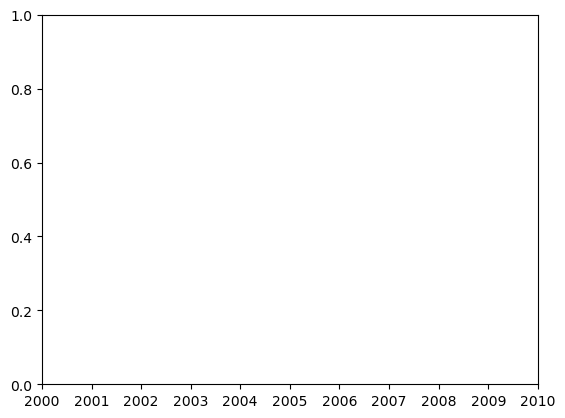

In [178]:
pd.concat(ds).interpolate().plot()

In [126]:
ya = pd.read_csv(year_file, parse_dates=['Week'], index_col=0)
ta = pd.read_csv(two_year_file)

ta.index = ta.apply(
    lambda row: pd.Timestamp(str(row.YEAR)) + row['Week No'] * pd.Timedelta(weeks=1)
    , axis=1
    )

In [125]:
ya.sort_index().tail()

,B6 - SCOTEX,B6 import - HARETORIM,B5 - SSE+GRM,B2 - SSEN-S,B4 - SSE-SP2,B5 - NKILGRMO,SW1 - SWALEX,LE1 - SEIMPPR2,no equivalent - HUMBEREX,B15 - ESTEX,B7 - SSHARN3
Week,,,,,,,,,,,
2022-02-28,4650,3500,2700,2950,2700,1900,3200,7000,7000,7500,6600
2022-03-07,4650,3500,2700,2950,2700,1900,3200,6200,7000,6200,7000
2022-03-14,4650,3500,2700,2950,2700,1900,3200,6200,6700,6000,7000
2022-03-21,4650,3500,2700,2950,2700,1900,3200,6200,6700,5700,7000
2022-03-28,4650,3500,2700,2950,2700,1900,3200,6500,6700,5700,6800


In [128]:
ta.sort_index()

,YEAR,Week No,DRESHEX1,ESTEX,FLOWSTH,GM+ SNOW5A,NKILGRMO,SCOAST2,SCOTEX ASACS,SEIMPPR2,SSE+GRM,SSEN-S,SSE-SP2,SSHARN3 (With HVDC)
2024-01-08,2024,1,9286,8772,11782,4132,2800,7848,5864,9230,2800,2943,3283,8947
2024-01-15,2024,2,9143,8772,11782,4132,2700,7848,5864,9230,2700,2943,3283,8815
2024-01-22,2024,3,8711,8461,11573,4132,2800,7848,5864,8918,2800,2943,3283,8682
2024-01-29,2024,4,9114,8630,11573,4132,2800,7848,5864,9003,2800,2943,3283,8762
2024-02-05,2024,5,8050,8630,11391,4132,2800,7848,5864,9173,2800,2943,3283,8735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-09-10,2026,36,99999,4900,10500,5300,2310,4450,4600,5750,2330,2038,2213,7100
2026-09-17,2026,37,99999,4500,10850,4800,2310,4550,4600,7500,2320,2038,2213,7050
2026-09-24,2026,38,99999,5475,9800,3875,2310,5350,4650,7275,2250,2038,2213,6150
2026-10-01,2026,39,99999,5475,9425,3675,2310,5350,4700,7300,2280,2038,2213,6100


In [92]:
a = pd.read_csv(
    Path.cwd().parent / 'data' / '24-months-ahead-constraint-limit_060924.csv'
)

In [121]:
a.sort_index()

,YEAR,Week No,DRESHEX1,ESTEX,FLOWSTH,GM+ SNOW5A,NKILGRMO,SCOAST2,SCOTEX ASACS,SEIMPPR2,SSE+GRM,SSEN-S,SSE-SP2,SSHARN3 (With HVDC)
2024-01-08,2024,1,9286,8772,11782,4132,2800,7848,5864,9230,2800,2943,3283,8947
2024-01-15,2024,2,9143,8772,11782,4132,2700,7848,5864,9230,2700,2943,3283,8815
2024-01-22,2024,3,8711,8461,11573,4132,2800,7848,5864,8918,2800,2943,3283,8682
2024-01-29,2024,4,9114,8630,11573,4132,2800,7848,5864,9003,2800,2943,3283,8762
2024-02-05,2024,5,8050,8630,11391,4132,2800,7848,5864,9173,2800,2943,3283,8735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2026-09-10,2026,36,99999,4900,10500,5300,2310,4450,4600,5750,2330,2038,2213,7100
2026-09-17,2026,37,99999,4500,10850,4800,2310,4550,4600,7500,2320,2038,2213,7050
2026-09-24,2026,38,99999,5475,9800,3875,2310,5350,4650,7275,2250,2038,2213,6150
2026-10-01,2026,39,99999,5475,9425,3675,2310,5350,4700,7300,2280,2038,2213,6100


In [141]:
from io import StringIO
from tqdm import tqdm

filler = '060924'
template = 'https://api.neso.energy/dataset/d515b4a9-60a1-489c-a126-004efc04f121/resource/3c359e33-3dac-4bdd-87d1-efbf4cbc2f07/download/24-months-ahead-constraint-limit_{}.csv'

response = requests.get(template.format(filler))
df = pd.read_csv(StringIO(response.text))
print(df.head())

for date in tqdm(pd.date_range('2023-10', '2025', freq='d')):
    url = template.format(date.strftime('%y%m%d'))
    response = requests.get(url)
    print(date, response.status_code)
    df = pd.read_csv(StringIO(response.text))
    print(url)
    print(df.head())

    break
    if response.status_code != 200:
        print(date)
        break



response = requests.get(url.format(filler))
print(response.status_code)

df

   YEAR  Week No  DRESHEX1  ESTEX  FLOWSTH  GM+ SNOW5A  NKILGRMO  SCOAST2  \
0  2024       40      6250   5650    10150        4900      2090     5550   
1  2024       41      6000   5050    11050        4900      2070     5750   
2  2024       42      6750   5550    11100        4750      2140     5575   
3  2024       43      7800   5550    11100        4100      2190     5550   
4  2024       44      8675   5600    10300        2750      2250     5500   

   SCOTEX ASACS  SEIMPPR2  SSE+GRM  SSEN-S  SSE-SP2  SSHARN3 (With HVDC)  
0          4980      6400     2250    2100     2000                 8250  
1          5130      6250     2290    1980     2010                 7800  
2          5150      6400     2300    2000     2200                 7600  
3          5200      6350     2340    2180     2270                 7450  
4          5350      6200     2380    2280     2250                 8650  


  0%|          | 0/459 [00:01<?, ?it/s]

2023-10-01 00:00:00 200
https://api.neso.energy/dataset/d515b4a9-60a1-489c-a126-004efc04f121/resource/3c359e33-3dac-4bdd-87d1-efbf4cbc2f07/download/24-months-ahead-constraint-limit_231001.csv
   YEAR  Week No  DRESHEX1  ESTEX  FLOWSTH  GM+ SNOW5A  NKILGRMO  SCOAST2  \
0  2024       40      6250   5650    10150        4900      2090     5550   
1  2024       41      6000   5050    11050        4900      2070     5750   
2  2024       42      6750   5550    11100        4750      2140     5575   
3  2024       43      7800   5550    11100        4100      2190     5550   
4  2024       44      8675   5600    10300        2750      2250     5500   

   SCOTEX ASACS  SEIMPPR2  SSE+GRM  SSEN-S  SSE-SP2  SSHARN3 (With HVDC)  
0          4980      6400     2250    2100     2000                 8250  
1          5130      6250     2290    1980     2010                 7800  
2          5150      6400     2300    2000     2200                 7600  
3          5200      6350     2340    2180   

200


,YEAR,Week No,DRESHEX1,ESTEX,FLOWSTH,GM+ SNOW5A,NKILGRMO,SCOAST2,SCOTEX ASACS,SEIMPPR2,SSE+GRM,SSEN-S,SSE-SP2,SSHARN3 (With HVDC)
0,2024,40,6250,5650,10150,4900,2090,5550,4980,6400,2250,2100,2000,8250
1,2024,41,6000,5050,11050,4900,2070,5750,5130,6250,2290,1980,2010,7800
2,2024,42,6750,5550,11100,4750,2140,5575,5150,6400,2300,2000,2200,7600
3,2024,43,7800,5550,11100,4100,2190,5550,5200,6350,2340,2180,2270,7450
4,2024,44,8675,5600,10300,2750,2250,5500,5350,6200,2380,2280,2250,8650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,2026,36,99999,4900,10500,5300,2310,4450,4600,5750,2330,2038,2213,7100
101,2026,37,99999,4500,10850,4800,2310,4550,4600,7500,2320,2038,2213,7050
102,2026,38,99999,5475,9800,3875,2310,5350,4650,7275,2250,2038,2213,6150
103,2026,39,99999,5475,9425,3675,2310,5350,4700,7300,2280,2038,2213,6100


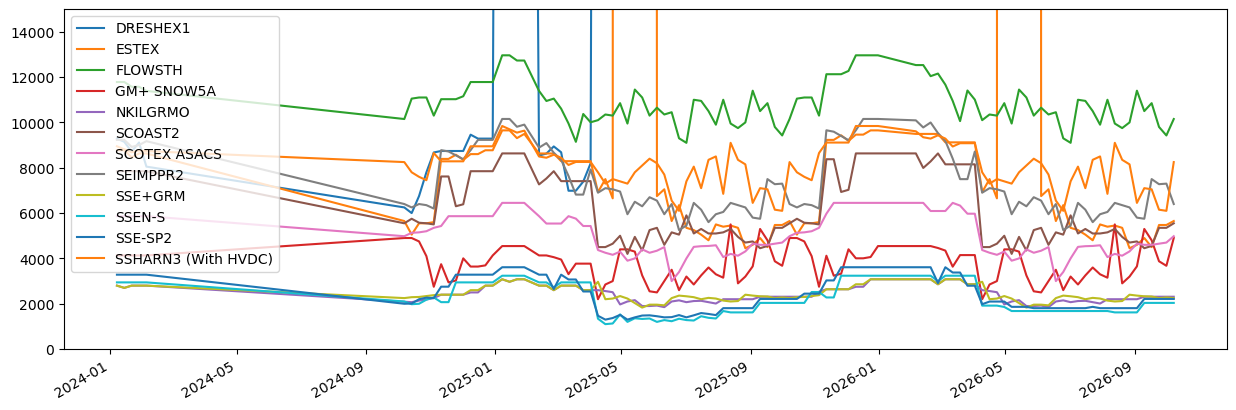

In [143]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(15, 5))

a.drop(columns=['YEAR', 'Week No']).sort_index().plot(ax=ax)
ax.set_ylim(0, 15000)

plt.show()